In [75]:
%reset

In [1]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

In [2]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.3),
     transforms.RandomVerticalFlip(0.3),
     transforms.RandomRotation(15),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
     transforms.ToTensor(),
     transforms.RandomErasing(0.1),
     transforms.GaussianBlur(1.0),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

# Load and split data

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [4]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH)
idx_to_class = tuple([k for k, _ in dataset.class_to_idx.items()])
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(range(len(dataset)), [n_train_examples, n_val_examples])
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [5]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Peek data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


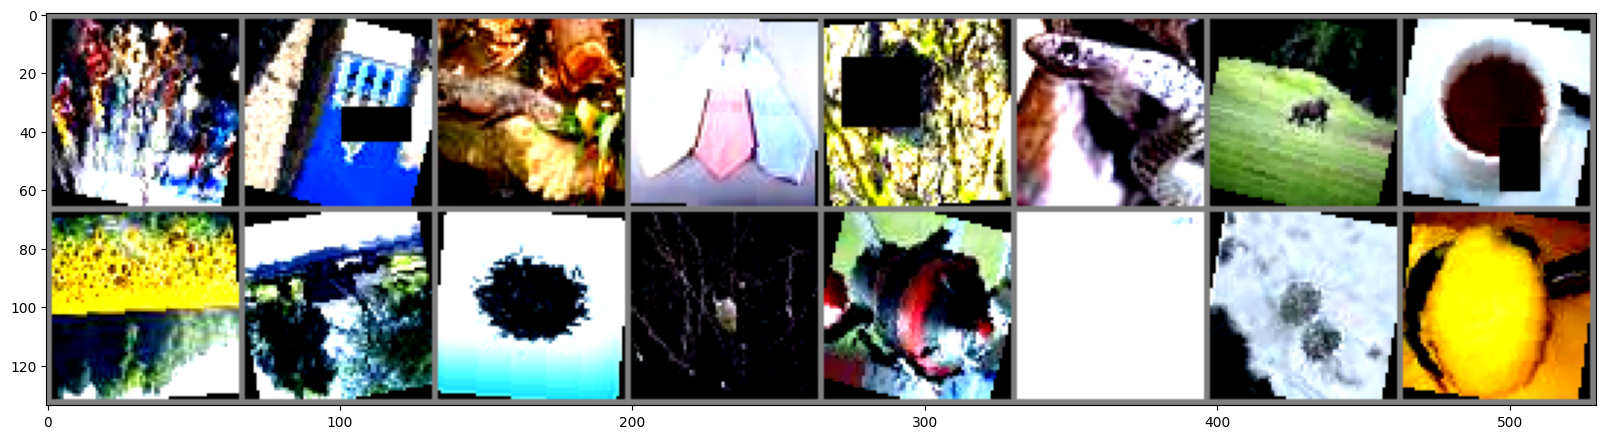

gauge acoustic crocodilian towel nest snake swine tea flower truck carbon bird bomb frog bacteria icecream


In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [8]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(val_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

NameError: name 'val_loader' is not defined

In [7]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 192, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((None, 6))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2688, 1028)
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [44]:
model = CNN(len(dataset.classes)).to(device)

In [45]:
model

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPoo

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 30
(
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies,
    train_f1_scores,
    val_f1_scores,
) = ([], [], [], [], [], [])
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(val_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)

    model.eval()
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = criterion(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)

    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
        }
    )


0it [09:06, ?it/s]
  0%|          | 0/30 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_train = model(inputs)
        predicted_argmax_train = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, labels))
        predicted_train = torch.cat((predicted_train, predicted_argmax_train))

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_val = model(inputs)
        predicted_argmax_val = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, labels))
        predicted_val = torch.cat((predicted_val, predicted_argmax_val))


In [35]:
labels_train, predicted_train = labels_train.cpu() , predicted_train.cpu()
labels_val, predicted_val = labels_val.cpu() , predicted_val.cpu()

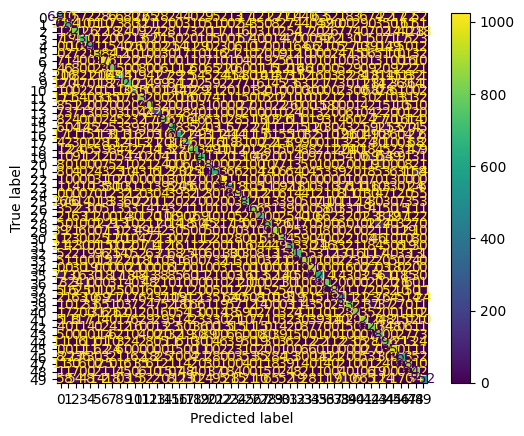

In [36]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [37]:
f1_score(labels_train, predicted_train, average='micro')

0.7246903760936257

In [38]:
mca_eval = MulticlassAccuracy(num_classes=50, average=None)

In [39]:
mca_eval(predicted_train, labels_train)

tensor([0.6343, 0.6663, 0.7639, 0.6725, 0.6526, 0.8526, 0.8892, 0.7533, 0.4609,
        0.6582, 0.6082, 0.7896, 0.8383, 0.7258, 0.7335, 0.6551, 0.5636, 0.6747,
        0.6608, 0.6789, 0.8299, 0.6115, 0.9579, 0.6613, 0.8313, 0.7254, 0.7901,
        0.6570, 0.6770, 0.8132, 0.7702, 0.6922, 0.6478, 0.8349, 0.8663, 0.5637,
        0.7625, 0.8088, 0.5873, 0.7561, 0.7904, 0.7514, 0.7464, 0.7233, 0.7236,
        0.8845, 0.6314, 0.8492, 0.8013, 0.5140])

In [40]:
f1_score(labels_val, predicted_val, average='micro')

0.7305212327794347

In [41]:
mca_eval(predicted_val, labels_val)

tensor([0.6587, 0.6606, 0.7597, 0.6831, 0.6434, 0.8616, 0.9013, 0.7548, 0.5275,
        0.6816, 0.5853, 0.7839, 0.8357, 0.6114, 0.7669, 0.6359, 0.5863, 0.6919,
        0.6587, 0.6563, 0.8164, 0.6282, 0.9508, 0.6608, 0.8502, 0.7188, 0.8310,
        0.6163, 0.7269, 0.8136, 0.7989, 0.7085, 0.5980, 0.8589, 0.8740, 0.5873,
        0.7470, 0.7781, 0.6186, 0.7287, 0.8265, 0.7708, 0.7486, 0.7570, 0.7657,
        0.8649, 0.5782, 0.8669, 0.8156, 0.5372])

In [42]:
mca_eval = MulticlassAccuracy(num_classes=50, average='macro')
mca_eval(predicted_val, labels_val)

tensor(0.7277)

Text(0, 0.5, 'Loss')

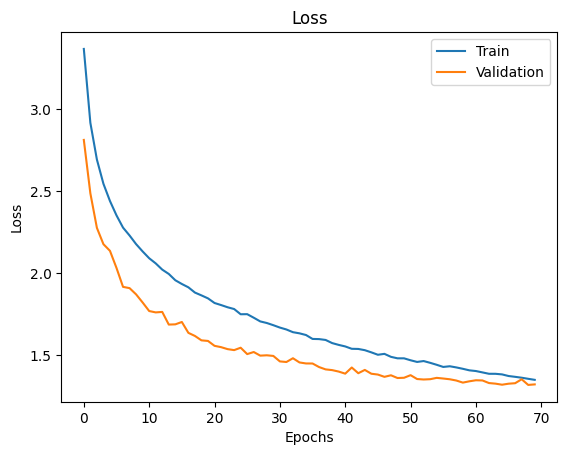

In [98]:

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label = "Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Save model's state dict

In [99]:
path = "../models/m.pth"
torch.save(model.state_dict(), path)

# Train on full data

In [8]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH)
train_dataset = CustomDataset(dataset, transform=transform_train)


In [29]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
model = CNN(len(dataset.classes)).to(device)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 100
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num= len(train_loader)

for epoch in tqdm_progress:
    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1
        }
    )

 35%|███▌      | 35/100 [20:53<38:46, 35.79s/it, Epoch=35]

### Save model

In [114]:
# path = "../models/model_all_data_trained.pth"
# torch.save(model.state_dict(), path)

## Load test dataset

In [10]:
TEST_DATA_PATH = "../test"
test_datasetimg_folder = datasets.ImageFolder(root=TEST_DATA_PATH)
test_dataset = CustomDataset(test_datasetimg_folder, transform=transform_val)


In [17]:
model = CNN(len(dataset.classes)).to(device)
model.load_state_dict(torch.load("../models/model_66.pth"))

<All keys matched successfully>

In [15]:
device = torch.device("cpu")

In [24]:
import os
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=6)
predictions = []
filenames = []
counter = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        predicts_test = model(inputs)
        predicted_argmax_test = torch.argmax(predicts_test, dim=1)
        
        filenames_batch = [os.path.basename(test_dataset.dataset.imgs[i][0]) for i in range(inputs.size(0)* counter, inputs.size(0)*(counter+1))]
        # print(filenames_batch)
        filenames.extend(filenames_batch)
        
        predictions_batch = predicted_argmax_test.cpu().numpy()
        # print(predictions_batch)
        predictions.extend(predictions_batch)
        counter += 1


## Save predictions

In [25]:
result = pd.DataFrame({"Filename": filenames, "Predicted": predictions})
result.to_csv("../predictions/predictions.csv", index=False, header=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


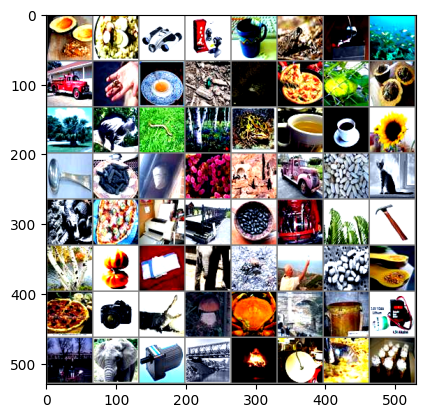

In [21]:
# get some random training images
images, labels = next(iter(test_loader))

# show images
imshow(torchvision.utils.make_grid())


In [46]:
dataset.class_to_idx

{'acoustic': 0,
 'antenna': 1,
 'bacteria': 2,
 'battery': 3,
 'bean': 4,
 'beetle': 5,
 'bicycle': 6,
 'birch': 7,
 'bird': 8,
 'bomb': 9,
 'bread': 10,
 'bridge': 11,
 'camera': 12,
 'carbon': 13,
 'cat': 14,
 'corn': 15,
 'crab': 16,
 'crocodilian': 17,
 'echinoderm': 18,
 'egg': 19,
 'elephant': 20,
 'fish': 21,
 'flower': 22,
 'frog': 23,
 'fungus': 24,
 'gauge': 25,
 'hammer': 26,
 'icecream': 27,
 'kangaroo': 28,
 'memorial': 29,
 'monkey': 30,
 'motor': 31,
 'nest': 32,
 'palm': 33,
 'pizza': 34,
 'pot': 35,
 'printer': 36,
 'saw': 37,
 'snake': 38,
 'spice': 39,
 'spider': 40,
 'spoon': 41,
 'squash': 42,
 'swine': 43,
 'tea': 44,
 'tomato': 45,
 'towel': 46,
 'truck': 47,
 'turtle': 48,
 'worm': 49}